In [50]:
%pip install llama-index-vector-stores-lancedb
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-embeddings-clip
%pip install git+https://github.com/openai/CLIP.git
!pip install llama-index-readers-file

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-iufjw4_c
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-iufjw4_c
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [51]:
%pip install llama_index
%pip install -U openai-whisper

In [52]:
%pip install lancedb
%pip install moviepy
%pip install pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install ftfy regex tqdm

In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

In [53]:
import os
from google.colab import userdata
OPENAI_API_TOKEN=userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [54]:
pip install pytubefix

In [55]:
from pytubefix import YouTube
from pytubefix.cli import on_progress

In [56]:
import os
print(os.getcwd())

/content


In [57]:
video_url="https://youtu.be/Mi44qCS6bR4"
output_video_path = "/content/video_data/"

output_folder = "/content/mixed_data/"
output_audio_path = "/content/mixed_data/output_audio.wav"

In [58]:
!mkdir mixed_data

mkdir: cannot create directory ‘mixed_data’: File exists


In [59]:
filepath=output_video_path + "input_vid.mp4"
print(filepath)

/content/video_data/input_vid.mp4


In [60]:
from pytubefix import YouTube
from pytubefix.cli import on_progress
def download_video(url,output_path):
  yt = YouTube(url)
  metadata = {"Author": yt.author, "Title": yt.title, "Views": yt.views}

  yt.streams.get_highest_resolution().download(
        output_path=output_path, filename="input_vid.mp4"
    )
  return metadata

In [61]:
from moviepy.editor import VideoFileClip
def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2
  )

In [62]:
def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

In [63]:
def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text

In [64]:
video_url
output_video_path

'/content/video_data/'

In [65]:
metadata_vid = download_video(video_url, output_video_path)

In [66]:
metadata_vid

{'Author': 'Firstpost',
 'Title': 'Paris 2024 Why Are Athletes Leaving Olympics Village For Hotels?  First Sports With Rupha Ramani',
 'Views': 1160756}

In [67]:
video_to_images(filepath,output_folder)

Moviepy - Writing frames /content/mixed_data/frame%04d.png.


Moviepy - Done writing frames /content/mixed_data/frame%04d.png.


In [68]:
video_to_audio(filepath,output_audio_path)

MoviePy - Writing audio in /content/mixed_data/output_audio.wav


MoviePy - Done.


In [69]:
text_data=audio_to_text(output_audio_path)

In [70]:
text_data

" Alright, in the quest of being the greenest and the greatest Olympics, Paris is turning out to be a bit problematic for the athletes. It's like students in the class of a very strict teacher. They realise soon enough that it is best to mess up and get punished to stand outside the classroom so that they can have their own fun and watch the other kids squirm. So what's making top athletes the world over squirm in Paris? Many of them are pretty fed up with the facilities that the games, that the games village is providing. The same village which was lauded for their out-of-the-box setup is now facing a mini-exodus. Students exiting classrooms in this case, athletes finding reasons to run away from the games village, ditching the prestigious games village for luxury hotels instead. So what's prompted them to leave proximity, safety and break the rules to do that? Take American tennis player Emma Navaro, for instance. Her biggest complaint is about the cardboard bets. Just to give you a 

In [71]:
with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()

Text data saved to file


In [72]:
os.remove(output_audio_path)
print("Audio file removed")

Audio file removed


In [73]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext

In [74]:
from llama_index.vector_stores.lancedb import LanceDBVectorStore

In [75]:
text_store=LanceDBVectorStore(uri="lancedb",table_name="text_collection")
image_store=LanceDBVectorStore(uri="lancedb",table_name="image_collection")

In [76]:
output_folder

'/content/mixed_data/'

In [77]:
storage_context=StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [78]:
documents=SimpleDirectoryReader(output_folder).load_data()


In [79]:
index = MultiModalVectorStoreIndex.from_documents(documents,storage_context=storage_context)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 130MiB/s]


In [80]:
retriever_engine=index.as_retriever(similarity_top_k=1, image_similarity_top_k=5)

In [81]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

In [82]:
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [83]:
query="can you tell me why Are athletes leaving olympics village For hotels ?"

In [87]:
img, text=  retrieve(retriever_engine,query)

**Node ID:** 75ed9583-a820-4b0c-9137-43cab1329856<br>**Similarity:** 0.7863050699234009<br>**Text:** Alright, in the quest of being the greenest and the greatest Olympics, Paris is turning out to be a bit problematic for the athletes. It's like students in the class of a very strict teacher. They ...<br>

In [88]:
import matplotlib.pyplot as plt
def plot_images(images_path):
  images_shown = 0
  plt.figure(figsize=(16, 9))
  for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 5:
                break

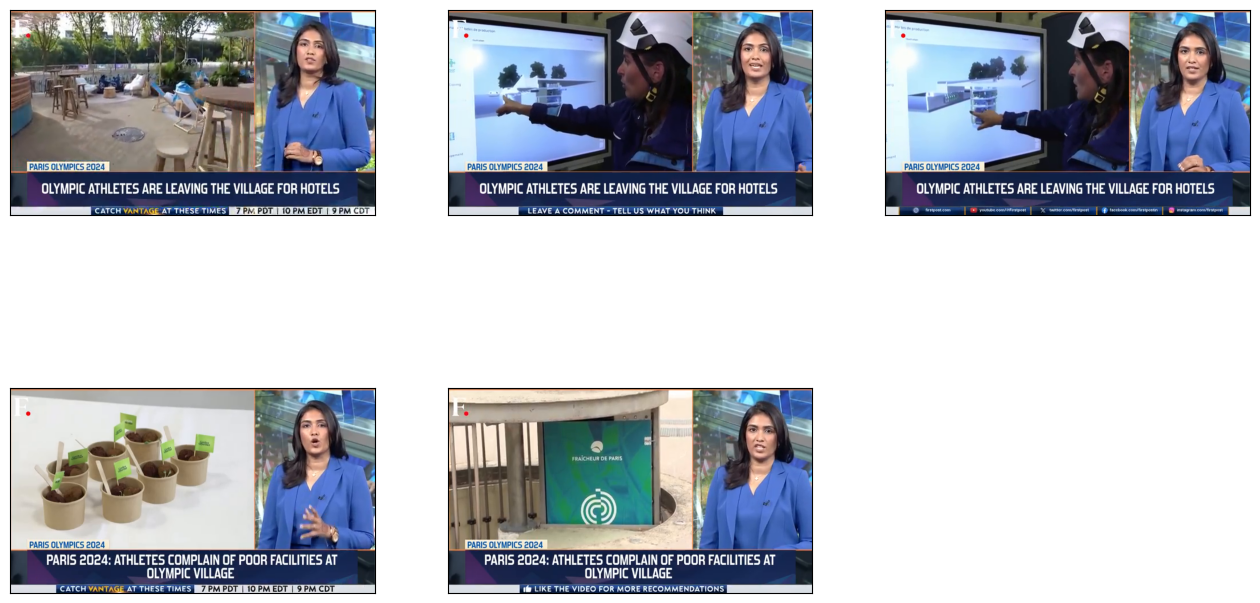

In [89]:
plot_images(img)

In [90]:
qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)


In [91]:
query_str="can you tell me why Are athletes leaving olympics village For hotels ?"

In [92]:
img

['/content/mixed_data/frame0008.png',
 '/content/mixed_data/frame0039.png',
 '/content/mixed_data/frame0031.png',
 '/content/mixed_data/frame0046.png',
 '/content/mixed_data/frame0038.png']

In [93]:
import json
metadata_str=json.dumps(metadata_vid)

In [94]:
context_str = "".join(text)

In [95]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

In [96]:
openai_mm_llm = OpenAIMultiModal(model="gpt-4o", api_key=OPENAI_API_TOKEN, max_new_tokens=1500)

In [97]:
image_documents = SimpleDirectoryReader( input_files=img).load_data()

In [98]:
result=openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
        query_str=query_str,metadata_str=metadata_str
    ),
    image_documents=image_documents
)


In [99]:
pprint(result.text)

('Athletes are leaving the Olympic Village for hotels due to complaints about '
 'poor facilities at the village. These issues include inadequate '
 'accommodations and amenities, which are prompting athletes to seek better '
 'living conditions elsewhere to ensure their comfort and performance during '
 'the Paris 2024 Olympics.')
